# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://open.spotify.com/track/4R3AU2pjv8ge2siX1fVbZs?si=b2712f32da0e4358) or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [1]:

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error
import joblib
import shap

In [2]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [3]:
categorical_features = ['month', 'day']
numerical_features = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']

In [4]:
X = fires_dt[numerical_features + categorical_features]
Y = fires_dt['area']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3,  random_state = 42)

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [5]:
preproc1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)
preproc1

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day'])])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [6]:
preproc2 = ColumnTransformer(
    transformers=[
        ('num', PowerTransformer(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)
preproc2

ColumnTransformer(transformers=[('num', PowerTransformer(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day'])])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [7]:
# Pipeline A = preproc1 + baseline

pipeline_A = Pipeline(steps=[('preprocessing', preproc1), ('regressor', KNeighborsRegressor())])
pipeline_A

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', KNeighborsRegressor())])

In [8]:
# Pipeline B = preproc2 + baseline
pipeline_B = Pipeline(steps=[('preprocessing', preproc2), ('regressor', KNeighborsRegressor())])
pipeline_B

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', PowerTransformer(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', KNeighborsRegressor())])

In [9]:
# Pipeline C = preproc1 + advanced model
pipeline_C = Pipeline(steps=[('preprocessing', preproc1), ('regressor', RandomForestRegressor())])
pipeline_C

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor())])

In [10]:
# Pipeline D = preproc2 + advanced model
pipeline_D = Pipeline(steps=[('preprocessing', preproc2), ('regressor', RandomForestRegressor())])
pipeline_D    

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', PowerTransformer(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor())])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [11]:
param_grid_A = {'regressor__n_neighbors': [3, 5, 7, 9]}
grid_A = GridSearchCV(pipeline_A, param_grid_A, cv=5, scoring='r2')
grid_A.fit(X_train, Y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', KNeighborsRegressor())]),
             param_grid={'regressor__n_neighbors': [3, 5, 7, 9]}, scoring='r2')

In [12]:
param_grid_B = {'regressor__n_neighbors': [3, 5, 7, 9]}
grid_B = GridSearchCV(pipeline_B, param_grid_B, cv=5, scoring='r2')
grid_B.fit(X_train, Y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         PowerTransformer(),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', KNeighborsRegressor())]),
             param_grid={'regressor__n_neighbors': [3, 5, 7, 9]}, scoring='r2')

In [13]:
param_grid_C = {'regressor__n_estimators': [50, 100, 150], 'regressor__max_depth': [None, 10, 20]}
grid_C = GridSearchCV(pipeline_C, param_grid_C, cv=5, scoring='r2')
grid_C.fit(X_train, Y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', RandomForestRegressor())]),
             param_grid={'regressor__max_depth': [None, 10, 20],
                         'regressor__n_estimators': [50, 100, 150]},
             scoring='r2')

In [14]:
param_grid_D = {'regressor__n_estimators': [50, 100, 150], 'regressor__max_depth': [None, 10, 20]}
grid_D = GridSearchCV(pipeline_D, param_grid_D, cv=5, scoring='r2')
grid_D.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         PowerTransformer(),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', RandomForestRegressor())]),
             param_grid={'regressor__max_depth': [None, 10, 20],
                         'regressor__n_estimators': [50, 100, 150]},
             scoring='r2')

In [15]:
best_model_A = grid_A.best_estimator_
best_model_B = grid_B.best_estimator_
best_model_C = grid_C.best_estimator_
best_model_D = grid_D.best_estimator_

In [16]:
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
# Get the best model from the grid search
estimators = [grid_A.best_estimator_, grid_B.best_estimator_,
              grid_C.best_estimator_, grid_D.best_estimator_]
labels = ['A', 'B', 'C', 'D']
for i , estimator in enumerate(estimators):
    
    # Make predictions on the training and test sets
    Y_pred_train = estimator.predict(X_train)
    Y_pred_test = estimator.predict(X_test)

    # Calculate performance metrics
    performance_metrics = {
        'r2_score_train': r2_score(Y_train, Y_pred_train),
        'r2_score_test': r2_score(Y_test, Y_pred_test),
        'mean_absolute_error_train': mean_absolute_error(Y_train, Y_pred_train),
        'mean_absolute_error_test': mean_absolute_error(Y_test, Y_pred_test),
        'mean_squared_error_train':  root_mean_squared_error(Y_train, Y_pred_train),
        'mean_squared_error_test':  root_mean_squared_error(Y_test, Y_pred_test),
    }
  
    # Display performance metrics
    print(f"\nPerformance Metrics for the Best Model {labels[i]}: \n")
    for metric, value in performance_metrics.items():
        print(f"{metric}: {value}")



Performance Metrics for the Best Model A: 

r2_score_train: 0.09120286834183822
r2_score_test: -0.01597144969129216
mean_absolute_error_train: 16.559375192366883
mean_absolute_error_test: 20.5355698005698
mean_squared_error_train: 46.21523881774152
mean_squared_error_test: 89.91673806298415

Performance Metrics for the Best Model B: 

r2_score_train: 0.09152143443768423
r2_score_test: -0.01283278757594597
mean_absolute_error_train: 16.704653739612187
mean_absolute_error_test: 20.41173789173789
mean_squared_error_train: 46.20713805569408
mean_squared_error_test: 89.77773978580548

Performance Metrics for the Best Model C: 

r2_score_train: 0.8367215747595549
r2_score_test: -0.10066423963230897
mean_absolute_error_train: 7.928053388734996
mean_absolute_error_test: 24.050865085470086
mean_squared_error_train: 19.589174247123818
mean_squared_error_test: 93.58951999504085

Performance Metrics for the Best Model D: 

r2_score_train: 0.8315077805920537
r2_score_test: -0.11647023508763099
mea

 **Selection of the best model**

In [17]:
scores = []
# Get the best model from the grid search
estimators = [grid_A.best_estimator_, grid_B.best_estimator_,
              grid_C.best_estimator_, grid_D.best_estimator_]
labels = ['KNeighborsRegressor with StandardScaler', 'KNeighborsRegressor with PowerTransformer',
          'RandomForestRegressor with StandardScaler', 'RandomForestRegressor with PowerTransformer']
for i , estimator in enumerate(estimators):
    
    # Make predictions on the training and test sets
    Y_pred_train = estimator.predict(X_train)
    Y_pred_test = estimator.predict(X_test)

    # Calculate performance metrics
    performance_metrics = {
        'r2_score_test': r2_score(Y_test, Y_pred_test)
    }
    scores.append([r2_score(Y_test, Y_pred_test), labels[i], estimator])
    # Display performance metrics
    print(f"\nPerformance Metrics for the ({labels[i]}) Model : \n")
    for metric, value in performance_metrics.items():
        print(f"{metric}: {value}")



Performance Metrics for the (KNeighborsRegressor with StandardScaler) Model : 

r2_score_test: -0.01597144969129216

Performance Metrics for the (KNeighborsRegressor with PowerTransformer) Model : 

r2_score_test: -0.01283278757594597

Performance Metrics for the (RandomForestRegressor with StandardScaler) Model : 

r2_score_test: -0.10066423963230897

Performance Metrics for the (RandomForestRegressor with PowerTransformer) Model : 

r2_score_test: -0.11647023508763099


In [18]:
best_score = max(scores, key=lambda x: x[0])

# Display the best score and model
print(f"Best model: {best_score[1]} with score: {best_score[0], best_score[2]}")

Best model: KNeighborsRegressor with PowerTransformer with score: (-0.01283278757594597, Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', PowerTransformer(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', KNeighborsRegressor(n_neighbors=9))]))


# Evaluate
+ Which model has the best performance?

Best model: KNeighborsRegressor with PowerTransformer with $R^2$ score = -0.01283278757594597 

# Export

+ Save the best performing model to a pickle file.

In [19]:
# Find the model with the best score
best_model= best_score[2]

# Export the best-performing model
joblib.dump(best_model, '../../05_src/data/models/best_forest_fire_model.pkl')


['../../05_src/data/models/best_forest_fire_model.pkl']

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [20]:
import shap

# Load the saved best performing model 
loaded_model = joblib.load('../../05_src/data/models/best_forest_fire_model.pkl')

data_transform = loaded_model.named_steps['preprocessing'].transform(X_test)

# Initialize the SHAP KernelExplainer
explainer = shap.KernelExplainer(
    model=loaded_model.named_steps['regressor'].predict, 
    data=data_transform  
)

# Compute SHAP values for the transformed test data
shap_values = explainer.shap_values(data_transform)

# Extract feature names from the preprocessing step
feature_names = loaded_model.named_steps['preprocessing'].get_feature_names_out()


Using 156 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/156 [00:00<?, ?it/s]

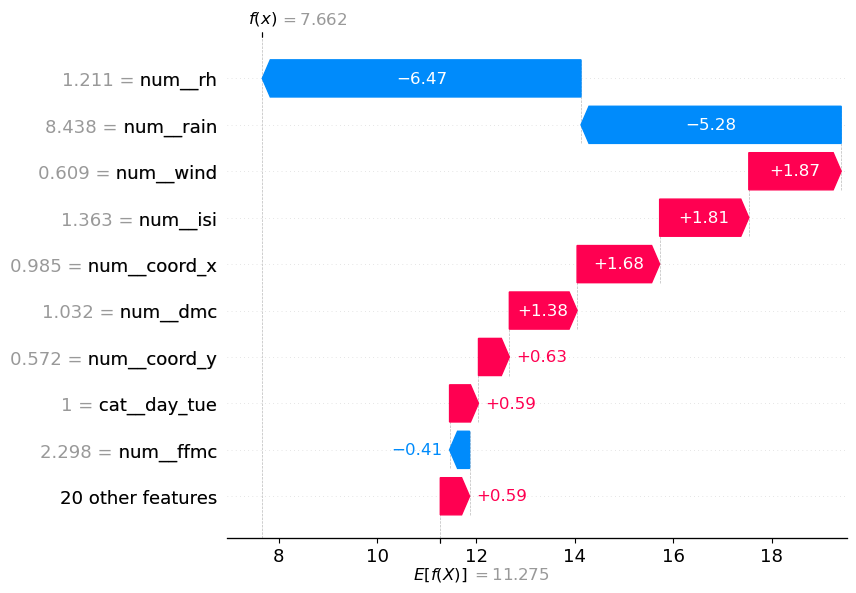

In [22]:
shap.plots.waterfall(shap.Explanation(
    values=shap_values[1], 
    base_values=explainer.expected_value, 
    data=data_transform[1], 
    feature_names=feature_names
))

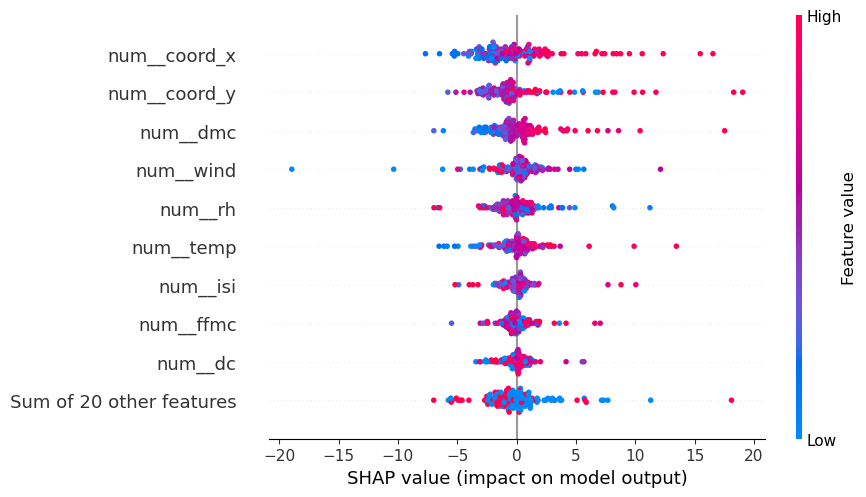

In [23]:
shap.plots.beeswarm(shap.Explanation(values=shap_values, 
                               base_values=explainer.expected_value, 
                               data=data_transform, 
                               feature_names=feature_names))

**num_coord_x, num_coord_y, num_wind, and num_dmc have a significant impact on the prediction, while features like num_ffmx, num_dc have smaller effect on  the predictions and can be removed.**

### **REFERNCES:**
-  https://maxsteele731.medium.com/shap-force-plots-for-classification-d30be430e195
-  https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/

## Criteria

The [rubric](./assignment_3_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.